<a href="https://colab.research.google.com/github/vaid02/mirror-detection/blob/main/mirror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade albumentations

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 66.0/66.0 kB 4.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 273.9/273.9 kB 11.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 632.7/632.7 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
%matplotlib inline
import os
import ast
from collections import namedtuple

import numpy as np # linear algebra

from tqdm import tqdm
from PIL import Image

import joblib
from joblib import Parallel, delayed

import cv2
import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2
# from albumentations.core.transforms_interface import DualTransform
# from albumentations.augmentations.bbox_utils import denormalize_bbox, normalize_bbox

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imsave

In [ ]:
def yolo_to_coco(yolo_annotation_path,image_width,image_height):

    bboxes = []
    category_ids = []

    with open(yolo_annotation_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_index = int(parts[0])
        x_center, y_center, box_width, box_height = map(float, parts[1:5])

        # Convert YOLO coordinates to COCO format
        x_min = int((x_center - box_width / 2) * image_width)
        y_min = int((y_center - box_height / 2) * image_height)
        coco_width = int(box_width * image_width)
        coco_height = int(box_height * image_height)

        bboxes.append([x_min,y_min,coco_width,coco_height])
        category_ids.append(class_index)

    return bboxes, category_ids

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
BASE_DIR = '/content/drive/MyDrive/MSD'
TRAIN_DIR = f"{BASE_DIR}/train/"

In [ ]:
!pwd

/content


In [ ]:
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_DIR = f"{TRAIN_DIR}image/"
LBL_DIR = f"{TRAIN_DIR}labels/"

In [ ]:
IMG_LIST = sorted(os.listdir(IMG_DIR))
LBL_LIST = sorted(os.listdir(LBL_DIR))

In [ ]:
category_id_to_name = {0: 'mirror'}

In [ ]:
img_num = 50

In [ ]:
img_path = os.path.join(IMG_DIR, IMG_LIST[img_num])
lbl_path = os.path.join(LBL_DIR, LBL_LIST[img_num])
print(img_path)
print(lbl_path)

/content/drive/MyDrive/MSD/train/image/1069_640x512.jpg
/content/drive/MyDrive/MSD/train/labels/1069_640x512.txt


In [ ]:
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
bboxes, category_ids = yolo_to_coco(lbl_path,640,640)

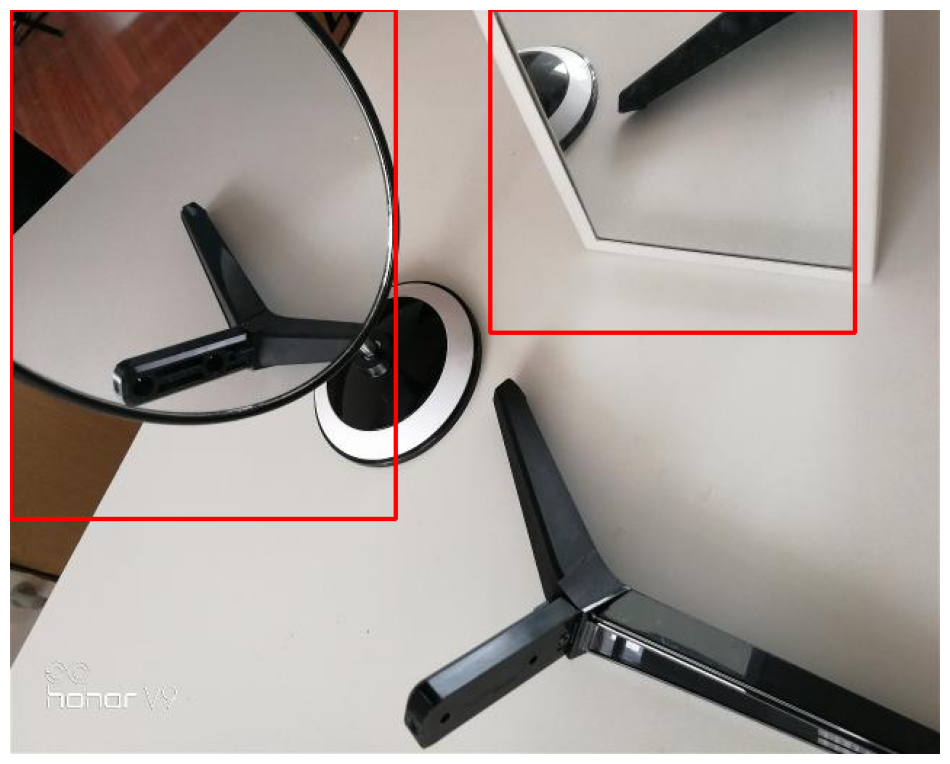

In [ ]:
visualize(image, bboxes, category_ids, category_id_to_name)


In [ ]:
!pip install ultralytics

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 911.6/911.6 kB 15.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/content/drive/MyDrive/MSD/data.yaml",  # path to dataset YAML
    epochs=50,  # number of training epochs
    imgsz=640,  # training image size
    device="cuda",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()



Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5.35M/5.35M [00:00<00:00, 48.3MB/s]


Ultralytics 8.3.65 üöÄ Python-3.11.11 torch-2.5.1+cu121 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.



image 1/1 /content/drive/MyDrive/MSD/train/images/1069_640x512.jpg: 512x640 2 mirrors, 43.2ms
Speed: 1.7ms preprocess, 43.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


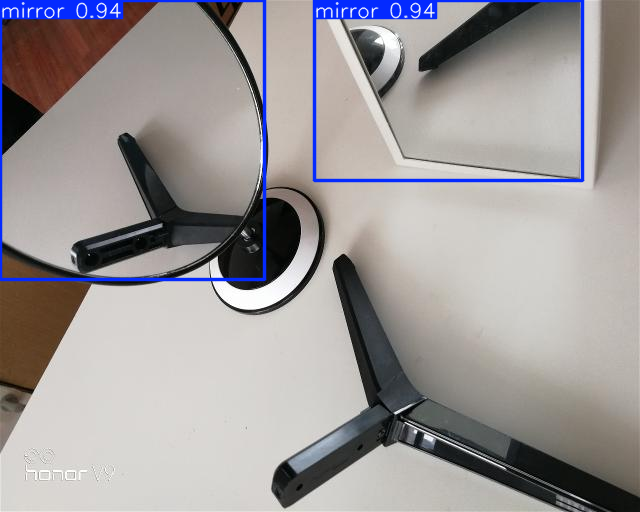

Ultralytics 8.3.65 üöÄ Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16.0/16.0 MB 181.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 142.8/142.8 kB 209.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 291.5/291.5 MB 82.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 46.0/46.0 kB 194.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚î

In [ ]:
# Perform object detection on an image
results = model("/content/drive/MyDrive/MSD/train/images/1069_640x512.jpg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

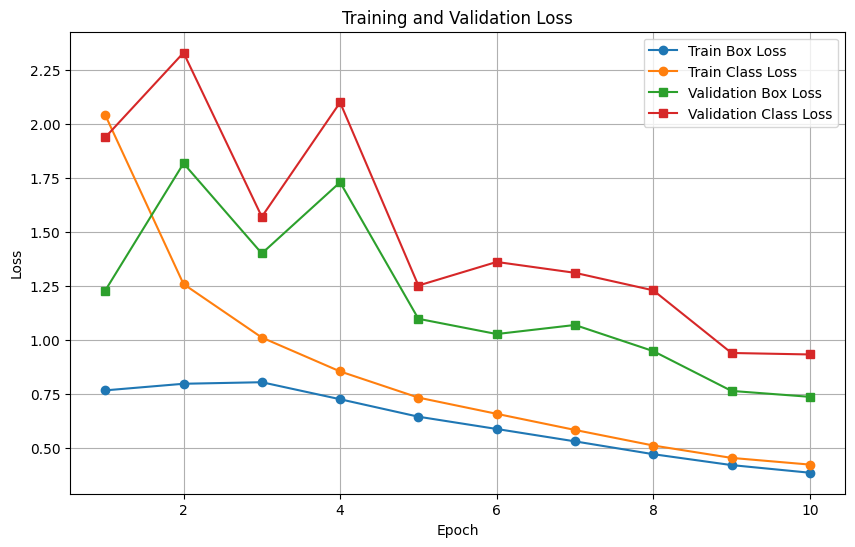

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Path to the results directory
results_dir = Path("/content/runs/detect/train")

# Load training log data
data = pd.read_csv(results_dir / "results.csv")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['train/box_loss'], label='Train Box Loss', marker='o')
plt.plot(data['epoch'], data['train/cls_loss'], label='Train Class Loss', marker='o')
plt.plot(data['epoch'], data['val/box_loss'], label='Validation Box Loss', marker='s')
plt.plot(data['epoch'], data['val/cls_loss'], label='Validation Class Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

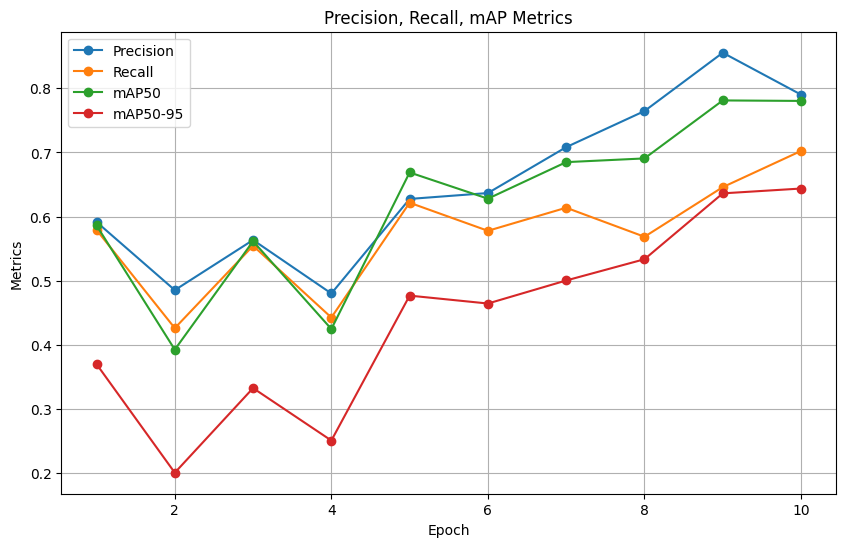

In [ ]:
# Plot precision, recall, and Fw1 score
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['metrics/precision(B)'], label='Precision', marker='o')
plt.plot(data['epoch'], data['metrics/recall(B)'], label='Recall', marker='o')
plt.plot(data['epoch'], data['metrics/mAP50(B)'], label='mAP50', marker='o')
plt.plot(data['epoch'], data['metrics/mAP50-95(B)'], label='mAP50-95', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision, Recall, mAP Metrics')
plt.legend()
plt.grid()
plt.show()

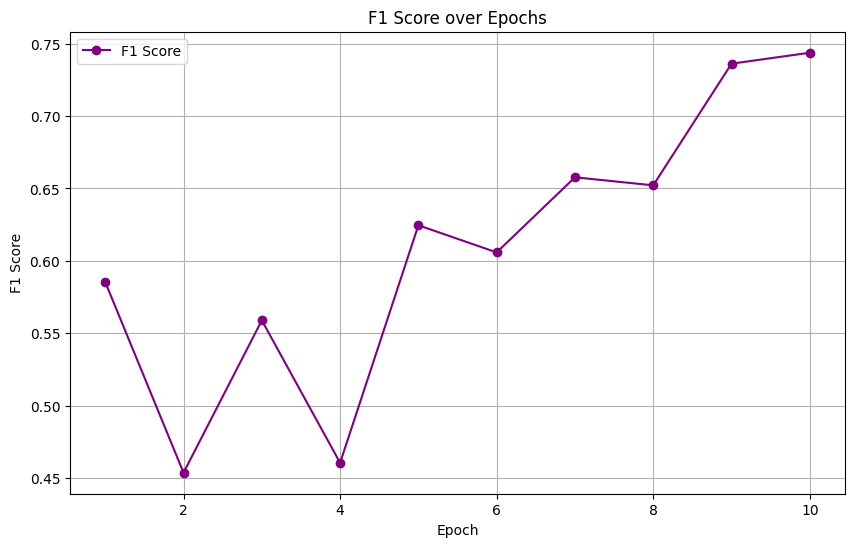

In [ ]:
# Plot F1 Score
f1_score = 2 * (data['metrics/precision(B)'] * data['metrics/recall(B)']) / (data['metrics/precision(B)'] + data['metrics/recall(B)'])
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], f1_score, label='F1 Score', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save("best_model.pt")

In [ ]:
from ultralytics import YOLO

# Load your trained YOLO model
model = YOLO("/content/best_model.pt")

# Export the YOLO model to TensorFlow SavedModel format
model.export(format="saved_model")  # This will automatically save the model in the current directory



Ultralytics 8.3.65 üöÄ Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/content/best_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.1 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx2tf>1.17.5,<=1.26.3', 'tflite_support'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 146.6/146.6 kB 67.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56.4/56.4 kB 153.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 445.6/445.6 kB 144.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.11M/1.11M [00:00<00:00, 160MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 47.88file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.47...
ONNX: export success ‚úÖ 1.4s, saved as '/content/best_model.onnx' (10.1 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.26.3...
TensorFlow SavedModel: export success ‚úÖ 69.7s, saved as '/content/best_model_saved_model' (26.2 MB)

Export complete (70.2s)
Results saved to /content
Predict:         yolo predict task=detect model=/content/best_model_saved_model imgsz=640  
Validate:        yolo val task=detect model=/content/best_model_saved_model imgsz=640 data=/content/drive/MyDrive/MSD/data.yaml  
Visualize:       https://netron.app


'/content/best_model_saved_model'

In [ ]:
import tensorflow as tf

# Load the exported TensorFlow SavedModel
saved_model_dir = "/content/best_model_saved_model"  # Path to the exported saved model directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = "/content/drive/MyDrive/MSD/yolo_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Model is now saved in TFLite format at the specified path


In [ ]:
from google.colab import files

# Download the TFLite model
files.download("/content/drive/MyDrive/MSD/yolo_model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>